In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
#call library

import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

from preprocesslib import preprocessEach, makeY

In [2]:
xGrowths = preprocessEach('growth')
xValues = preprocessEach('value')
xOverlaps = preprocessEach('overlap')

In [3]:
def bootstrap(large, small):
    diff = len(large) - len(small)
    bootstrapped = small[np.random.choice(len(small), size=diff, replace=True)]
    return np.concatenate((small, bootstrapped), axis=0)

In [4]:
xGrowths = bootstrap(xValues, xGrowths)
xOverlaps = bootstrap(xValues, xOverlaps)

In [5]:
#make y values
yGrowths = makeY('growth', len(xGrowths))
yValues = makeY('value', len(xValues))
yOverlaps = makeY('overlap', len(xOverlaps))

In [6]:
x = np.concatenate((xGrowths, xValues, xOverlaps), axis=0)
y = np.concatenate((yGrowths, yValues, yOverlaps), axis=0)

In [7]:
#minmax scaling by element
scaler = MinMaxScaler()
for i in range(6):
    x[:,:,i] = scaler.fit_transform(x[:,:,i])

In [9]:
def splitData(x, y, train_ratio=0.8):
    # shuffle data
    permutation = np.random.permutation(len(x))
    x = x[permutation]
    y = y[permutation]

    # split data
    n_train_samples = int(train_ratio * len(x))
    x_train, x_test = x[:n_train_samples], x[n_train_samples:]
    y_train, y_test = y[:n_train_samples], y[n_train_samples:]

    return x_train, x_test, y_train, y_test

In [10]:
x_train, x_test, y_train, y_test = splitData(x, y)

In [11]:
#modify NaN to 0
x_train = np.nan_to_num(x_train, nan=0)
x_test = np.nan_to_num(x_test, nan=0)

In [12]:
x_train.shape #2570 data samples, 1248 days, 6 features

(2570, 1248, 6)

## Baseline model

In [13]:
from tensorflow.keras.layers import SimpleRNN

In [14]:
model = Sequential()
model.add(SimpleRNN(32, input_shape=(1248, 6)))
model.add(Dense(8))
model.add(Dense(2, activation='sigmoid'))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1248      
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dense_1 (Dense)             (None, 2)                 18        
                                                                 
Total params: 1,530
Trainable params: 1,530
Non-trainable params: 0
_________________________________________________________________


In [16]:
history=model.fit(x_train, y_train, epochs=2000, validation_split=0.2, callbacks=[es,mc])

Epoch 1/2000
65/65 [==============================] - 8s 106ms/step - loss: 0.6647 - acc: 0.4499 - val_loss: 0.6364 - val_acc: 0.6790
Epoch 2/2000
65/65 [==============================] - 6s 99ms/step - loss: 0.6322 - acc: 0.5496 - val_loss: 0.6307 - val_acc: 0.6576
Epoch 3/2000
65/65 [==============================] - 7s 101ms/step - loss: 0.6249 - acc: 0.5963 - val_loss: 0.6298 - val_acc: 0.5136
Epoch 4/2000
65/65 [==============================] - 6s 99ms/step - loss: 0.6170 - acc: 0.5759 - val_loss: 0.6182 - val_acc: 0.5720
Epoch 5/2000
65/65 [==============================] - 7s 101ms/step - loss: 0.6168 - acc: 0.5885 - val_loss: 0.6314 - val_acc: 0.6479
Epoch 6/2000
65/65 [==============================] - 6s 98ms/step - loss: 0.6205 - acc: 0.6255 - val_loss: 0.6231 - val_acc: 0.5759
Epoch 7/2000
65/65 [==============================] - 7s 102ms/step - loss: 0.6179 - acc: 0.5661 - val_loss: 0.6197 - val_acc: 0.5720
Epoch 8/2000
65/65 [==============================] - 6s 99ms/ste

In [17]:
count_10 = np.sum((y_test == [1, 0]).all(axis=1))
count_01 = np.sum((y_test == [0, 1]).all(axis=1))
count_11 = np.sum((y_test == [1, 1]).all(axis=1))

print(f"[1, 0]의 개수: {count_10}")
print(f"[0, 1]의 개수: {count_01}")
print(f"[1, 1]의 개수: {count_11}")

[1, 0]의 개수: 201
[0, 1]의 개수: 230
[1, 1]의 개수: 212


In [21]:
best_model=load_model('best_model.h5')
loss, accuracy = best_model.evaluate(x_test, y_test)
y_pred_prob = best_model.predict(x_test)

21/21 [==============================] - 1s 27ms/step


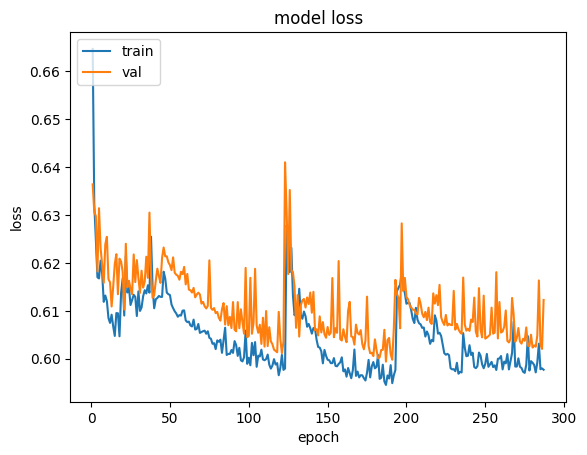

In [19]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

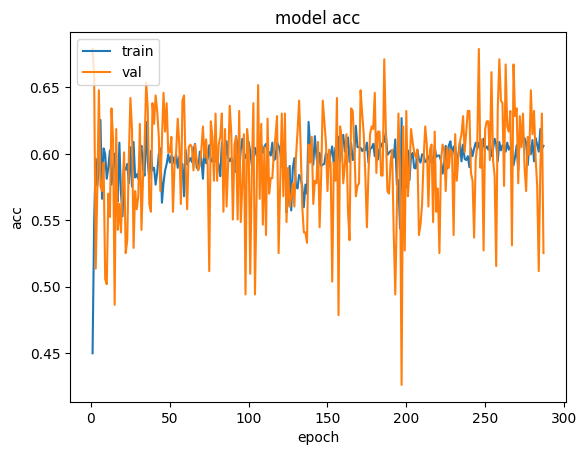

In [20]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()